In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tải dataset Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Lấy dữ liệu
data = dataset[0]

# Giả định năm ngẫu nhiên cho các bài báo trong khoảng từ 2000 đến 2005
np.random.seed(42)  # Đặt seed để kết quả ngẫu nhiên được tái hiện
data.year = torch.tensor(np.random.randint(2000, 2006, data.num_nodes))

# Kiểm tra cấu trúc dữ liệu
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], year=[2708])


In [2]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Khởi tạo mô hình
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [3]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# Lấy các dự đoán trên tập test
model.eval()
out = model(data.x, data.edge_index)
pred = out.max(1)[1]


Epoch 0, Loss: 1.9626, Train Acc: 0.5071, Val Acc: 0.2420, Test Acc: 0.2760
Epoch 10, Loss: 0.0896, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.7520
Epoch 20, Loss: 0.0033, Train Acc: 1.0000, Val Acc: 0.6900, Test Acc: 0.7160
Epoch 30, Loss: 0.0007, Train Acc: 1.0000, Val Acc: 0.7260, Test Acc: 0.7560
Epoch 40, Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.7440, Test Acc: 0.7730
Epoch 50, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.7460, Test Acc: 0.7820
Epoch 60, Loss: 0.0018, Train Acc: 1.0000, Val Acc: 0.7460, Test Acc: 0.7830
Epoch 70, Loss: 0.0031, Train Acc: 1.0000, Val Acc: 0.7440, Test Acc: 0.7800
Epoch 80, Loss: 0.0042, Train Acc: 1.0000, Val Acc: 0.7480, Test Acc: 0.7840
Epoch 90, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7520, Test Acc: 0.7890
Epoch 100, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7560, Test Acc: 0.7880
Epoch 110, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7900
Epoch 120, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.78

In [4]:
# Gán các dự đoán cho data
data.y_pred = pred

# Tạo DataFrame chứa thông tin bài báo và chủ đề
df = pd.DataFrame({
    'year': data.year.numpy(),
    'actual_topic': data.y.numpy(),
    'predicted_topic': data.y_pred.numpy()
})

# Tính tỷ lệ chủ đề từng năm
topic_year_df = df.groupby(['year', 'predicted_topic']).size().unstack(fill_value=0)
topic_year_df = topic_year_df.apply(lambda x: x / x.sum(), axis=1)

# Hiển thị tỷ lệ chủ đề từng năm
print(topic_year_df)

predicted_topic         0         1         2         3         4         5  \
year                                                                          
2000             0.129590  0.123110  0.138229  0.261339  0.179266  0.071274   
2001             0.129386  0.100877  0.140351  0.239035  0.184211  0.109649   
2002             0.136364  0.095694  0.148325  0.244019  0.198565  0.102871   
2003             0.120350  0.100656  0.146608  0.251641  0.188184  0.109409   
2004             0.125800  0.095949  0.157783  0.211087  0.181237  0.125800   
2005             0.164045  0.103371  0.146067  0.217978  0.173034  0.103371   

predicted_topic         6  
year                       
2000             0.097192  
2001             0.096491  
2002             0.074163  
2003             0.083151  
2004             0.102345  
2005             0.092135  


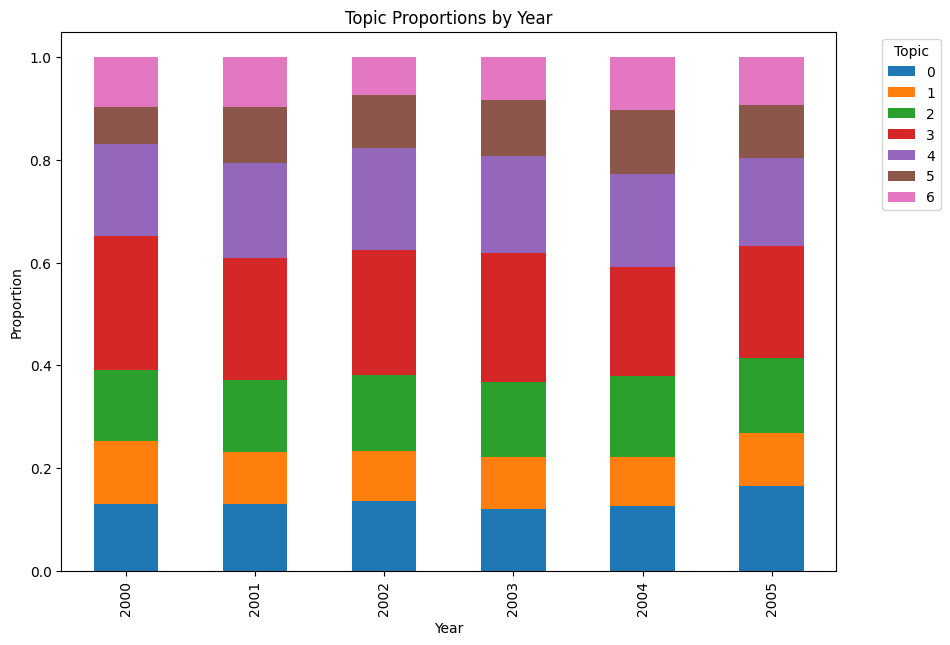

In [5]:
# Biểu đồ tỷ lệ chủ đề từng năm
topic_year_df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Topic Proportions by Year')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()